In [1]:
using  FFTW
using  LinearAlgebra
using  ProgressMeter
using  BenchmarkTools
using  Plots
pyplot()

Plots.PyPlotBackend()

In [9]:
#using FModels
include("mesh.jl")
include("times.jl")
include("fig.jl")

fig (generic function with 3 methods)

In [10]:

function main(mesh::Mesh, times::Times, Gamma::Vector{Float64})
    
    function solve!(h, u, times)
                
        prog = Progress(times.Nt,1) # progress bar
        
        dh, du = similar(h), similar(u)
        hhat, uhat = similar(h), similar(u)
        hnew, unew = similar(h), similar(u)
        
        Int1 = similar(u)
        Int2 = similar(h)
        Int3 = similar(h)
        
        Px  = plan_fft(hnew; flags = FFTW.MEASURE)

        function fwave!(h::Vector{Complex{Float64}},
                        u::Vector{Complex{Float64}})
             
             ldiv!(hnew, Px , h)
             
             Int1  .= u
             Int1 .*= Gamma
             ldiv!(unew, Px , Int1)
             unew  .^= 2
             mul!(Int1, Px , unew)
             Int1 .*= H
             
             Int2  .= h
             Int2 .*= Dx
             ldiv!(unew, Px , Int2)
             unew  .*= hnew
             mul!(Int2, Px , unew)
             
             Int3  .= h
             Int3 .*= Gamma
             ldiv!(unew, Px, Int3)
             unew  .*= hnew
             mul!(Int3 , Px , unew)
             Int3 .*= H
             
             hnew  .= -u
             hnew .*= Dx
             
             Int1 .-= Int2
             Int1 .-= Int3
             Int1 .*= Pi
             Int1 .*= epsilon
             
             u  .= h
             u .*= H
             u .+= Int1
             
             h .= hnew
             
        end
    
        function rk4!( h::Vector{Complex{Float64}},
                       u::Vector{Complex{Float64}})
            
            hhat .= h
            uhat .= u
            fwave!( hhat, uhat)
            dh .= hhat
            du .= uhat
            
            hhat .= h .+ dt/2*hhat
            uhat .= u .+ dt/2*uhat
            fwave!( hhat,uhat)
            dh .+= 2 * hhat
            du .+= 2 * uhat
            
            hhat .= h .+ dt/2*hhat
            uhat .= u .+ dt/2*uhat
            fwave!( hhat, uhat)
            dh .+= 2 * hhat
            du .+= 2 * uhat
            
            hhat .= h .+ dt*hhat
            uhat .= u .+ dt*uhat
            fwave!( hhat, uhat)
            dh .+= hhat
            du .+= uhat
            
            h .+= dt/6 * dh
            u .+= dt/6 * du
        end
        
        label = "Cheng et al."
        Modeles[label] = []
      
        push!(Modeles[label],(h,u))
        for l in range(1,times.Nt-1)
            
            dt = times.t[l+1]-times.t[l]
            
            rk4!( h, u)
        
            push!(Modeles[label],(h,u))   
            next!(prog)
        end
                
    end
    
    H     = -1im * sign.(mesh.k)     # Hilbert transform
    Dx    =  1im * mesh.k            # Differentiation
    Pi    = Gamma .< mesh.kmax * 2/3 # Dealiasing low-pass filter
    
    h     = zeros(Complex{Float64},N)
    h    .= exp.(-mesh.x.^2)
    h    .= Pi .* fft(h)
    u     = zeros(Complex{Float64},N)
    u    .= Pi .* fft(u)
    
    solve!(h, u, times )
    
end

main (generic function with 1 method)

(epsilon, N, L, T, dt) = (0.5, 4096, 10, 5, 0.001)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01

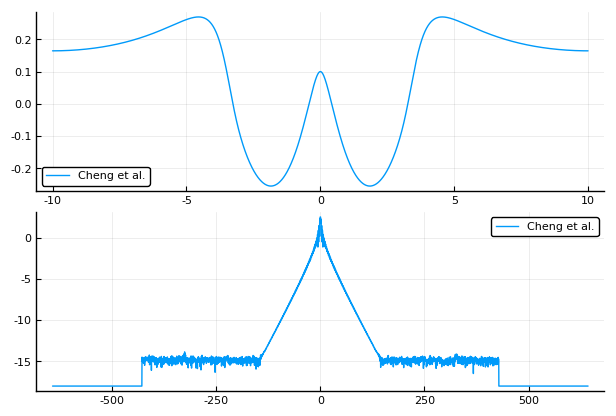

 12.032158 seconds (1.57 M allocations: 4.944 GiB, 6.26% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

In [11]:
epsilon = 1/2
N       = 2^12
L       = 10
T       = 5
dt      = 0.001

@show epsilon,N,L,T,dt

mesh  = Mesh(-L, L, N)
times = Times(dt, T)

Gamma   = abs.(mesh.k)
Modeles = Dict()
    
@time main(mesh, times, Gamma)
fig(5, times, Gamma, Modeles, epsilon, mesh)